In [3]:
#Importing required libraries

import matplotlib.pyplot as plt
import seaborn as sns

import os
import gc

from sklearn.model_selection import train_test_split


import tensorflow as tf
from tqdm.autonotebook import tqdm

import numpy as np #
import pandas as pd 

from keras import Sequential
from keras.callbacks import EarlyStopping

from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from keras.layers import Lambda, Input, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.utils import to_categorical
# from keras import regularizers
from tensorflow.keras.models import Model


from keras.preprocessing.image import load_img

In [4]:
print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")
tf.config.list_physical_devices("GPU")

GPU not available :(


[]

In [5]:
labels = pd.read_csv('labels.csv')
labels.head()


id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [6]:
#describe
labels.describe()

id               breed
count                              10222               10222
unique                             10222                 120
top     9b2b87ec7679c63db2d4061987e732f4  scottish_deerhound
freq                                   1                 126

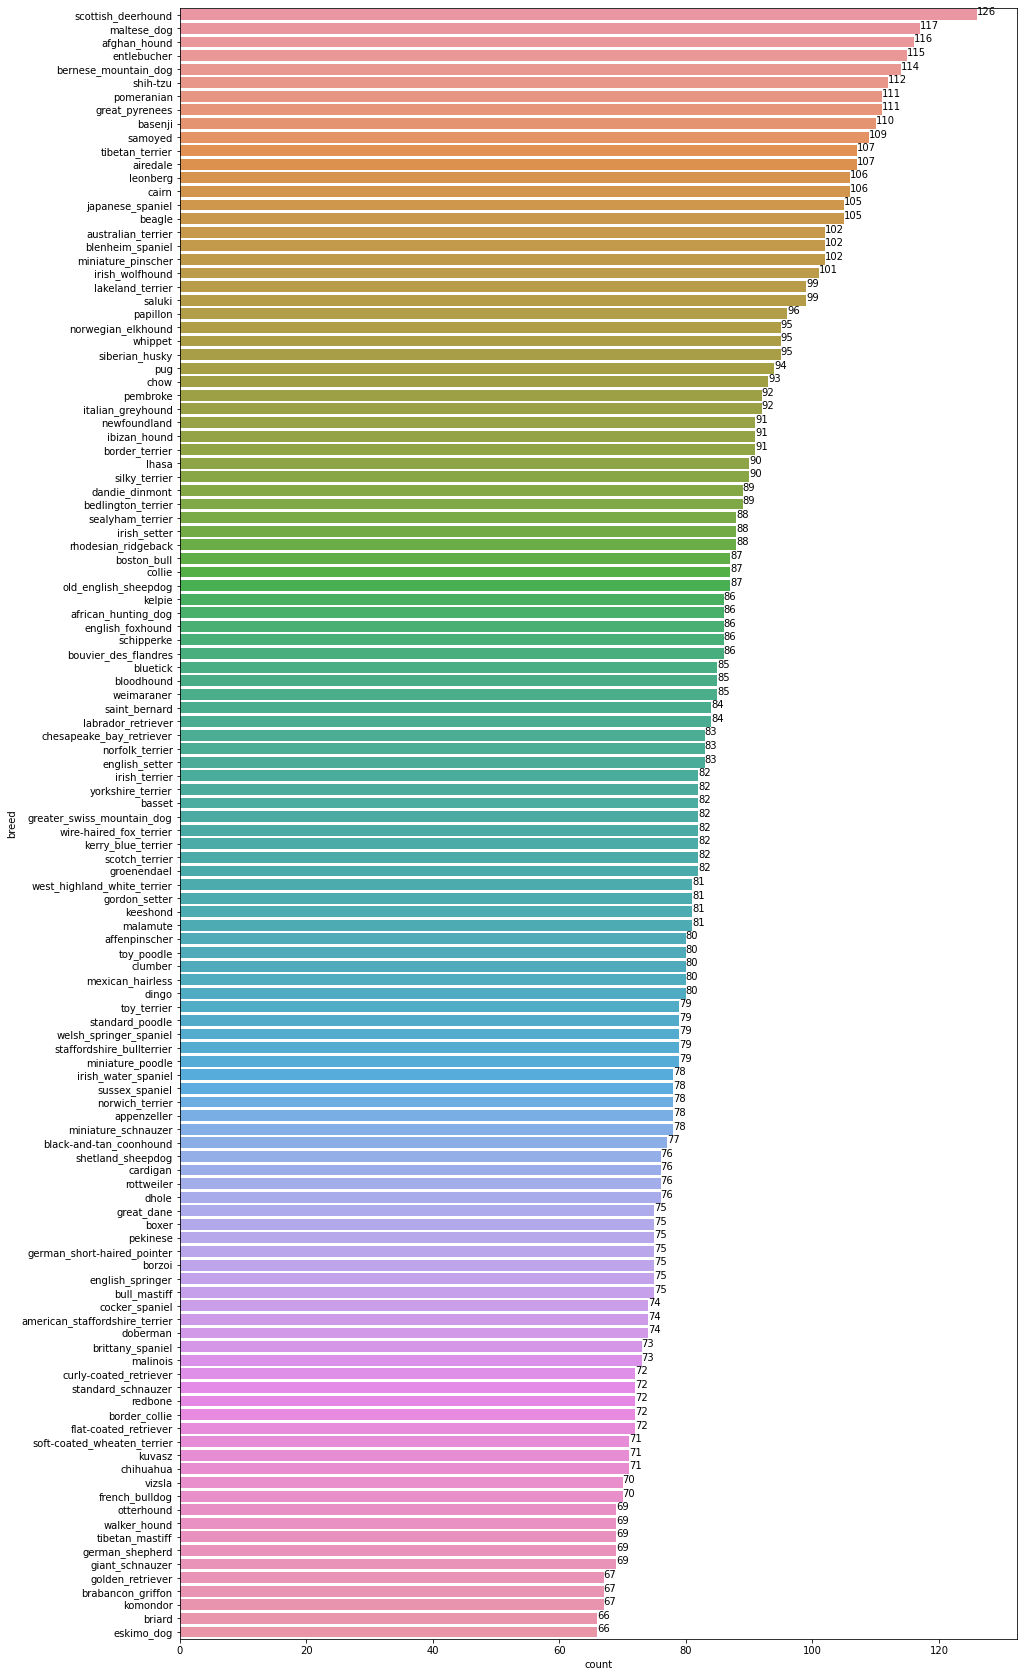

In [7]:
#function to show bar length
def barw(ax): 
    
    for p in ax.patches:
        val = p.get_width() #height of the bar
        x = p.get_x()+ p.get_width() # x- position 
        y = p.get_y() + p.get_height()/2 #y-position
        ax.annotate(round(val,2),(x,y))
        
#finding top dog brands

plt.figure(figsize = (15,30))
ax0 =sns.countplot(y=labels['breed'],order=labels['breed'].value_counts().index)
barw(ax0)
plt.show()

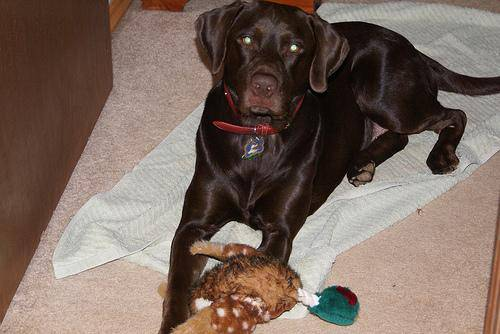

In [8]:
# Lets check one image
from IPython.display import display, Image
Image("train/43572ba7edf772a95f539e57afd9eb43.jpg")

In [9]:
import os
if len(os.listdir('train/')) == len(labels['id']):
    print('Number of file matches number of actual images!')
else:
    print('Number of file doesnot matches number of actual images!!')

Number of file matches number of actual images!


In [10]:
#Create list of alphabetically sorted labels.
classes = sorted(list(set(labels['breed'])))
n_classes = len(classes)
print('Total unique breed {}'.format(n_classes))



#Map each label string to an integer label.
class_to_num = dict(zip(classes, range(n_classes)))
class_to_num

Total unique breed 120


{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'

In [11]:
input_shape = (331,331,3)


def images_to_array(directory, label_dataframe, target_size = input_shape):
    
    image_labels = label_dataframe['breed']
    images = np.zeros([len(label_dataframe), target_size[0], target_size[1], target_size[2]],dtype=np.uint8) #as we have huge data and limited ram memory. uint8 takes less memory
    y = np.zeros([len(label_dataframe),1],dtype = np.uint8)
    
    for ix, image_name in enumerate(tqdm(label_dataframe['id'].values)):
        img_dir = os.path.join(directory, image_name + '.jpg')
        img = load_img(img_dir, target_size = target_size)
#         img = np.expand_dims(img, axis=0)
#         img = processed_image_resnet(img)
#         img = img/255
        images[ix]=img
#         images[ix] = img_to_array(img)
        del img
        
        dog_breed = image_labels[ix]
        y[ix] = class_to_num[dog_breed]
    
    y = to_categorical(y)
    
    return images,y


In [12]:
import time 
t = time.time()

X,y = images_to_array('train', labels[:])

print('runtime in seconds: {}'.format(time.time() - t))

100%|██████████| 10222/10222 [01:26<00:00, 117.99it/s]
runtime in seconds: 86.97711968421936


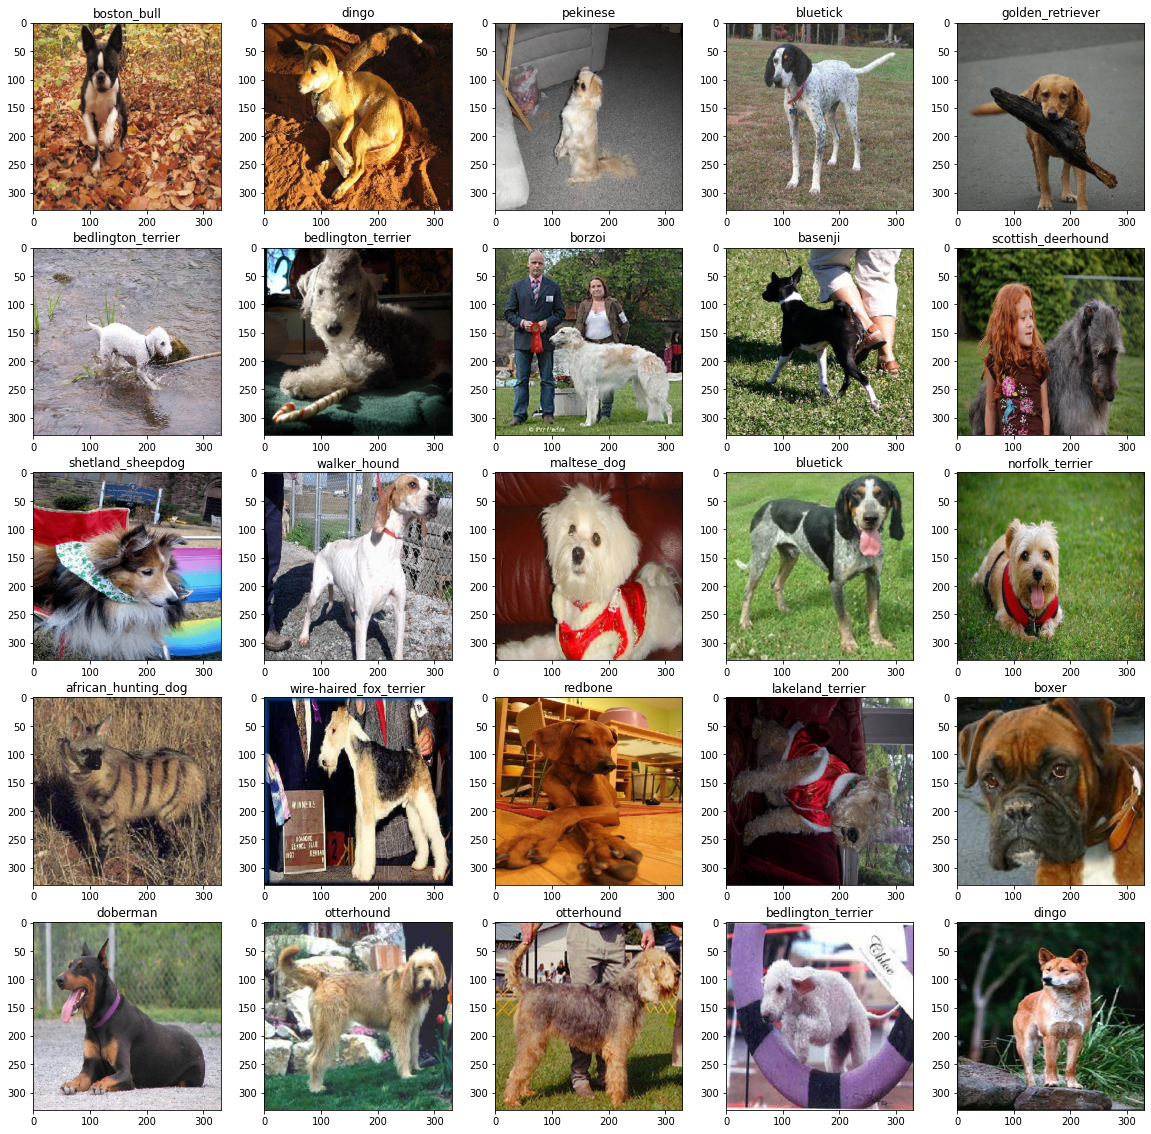

In [13]:
# lets check some dogs and their breeds
n=25

# setup the figure 
plt.figure(figsize=(20,20))

for i in range(n):
#     print(i)
    ax = plt.subplot(5, 5, i+1)
    plt.title(classes[np.where(y[i] ==1)[0][0]])
    plt.imshow(X[i].astype('int32')) # .astype('int32') ---> as imshow() needs integer data to read the image

In [14]:
#Learning Rate Annealer
lrr= ReduceLROnPlateau(monitor='val_acc', factor=.01, patience=3, min_lr=1e-5,verbose = 1)

#Prepare call backs
EarlyStop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [15]:
# Hyperparameters
batch_size= 128
epochs=50
learn_rate=.001
sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None,  amsgrad=False)

C:\Users\wiart\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [16]:
#function to extract features from the dataset by a given pretrained model
img_size = (331,331,3)

def get_features(model_name, model_preprocessor, input_size, data):

    input_layer = Input(input_size)
    preprocessor = Lambda(model_preprocessor)(input_layer)
    base_model = model_name(weights='imagenet', include_top=False,
                            input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)
    
    #Extract feature.
    feature_maps = feature_extractor.predict(data, verbose=1)
    print('Feature maps shape: ', feature_maps.shape)
    return feature_maps

In [17]:
# Extract features using InceptionV3 
from keras.applications.inception_v3 import InceptionV3, preprocess_input
inception_preprocessor = preprocess_input
inception_features = get_features(InceptionV3,
                                  inception_preprocessor,
                                  img_size, X)

320/320 [==============================] - 3560s 11s/step
Feature maps shape:  (10222, 2048)


In [18]:
# Extract features using Xception 
from keras.applications.xception import Xception, preprocess_input
xception_preprocessor = preprocess_input
xception_features = get_features(Xception,
                                 xception_preprocessor,
                                 img_size, X)

320/320 [==============================] - 5544s 17s/step
Feature maps shape:  (10222, 2048)


In [19]:
# Extract features using InceptionResNetV2 
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
inc_resnet_preprocessor = preprocess_input
inc_resnet_features = get_features(InceptionResNetV2,
                                   inc_resnet_preprocessor,
                                   img_size, X)

320/320 [==============================] - 7572s 24s/step
Feature maps shape:  (10222, 1536)


In [7]:
# Extract features using NASNetLarge 
from keras.applications.nasnet import NASNetLarge, preprocess_input
nasnet_preprocessor = preprocess_input
nasnet_features = get_features(NASNetLarge,nasnet_preprocessor,img_size, X)

NameError: name 'X' is not defined

In [ ]:
del X #to free up some ram memory
gc.collect()

In [ ]:
#Creating final featuremap by combining all extracted features

final_features = np.concatenate([inception_features,
                                 xception_features,
                                 nasnet_features,
                                 inc_resnet_features,], axis=-1) #axis=-1 to concatinate horizontally

print('Final feature maps shape', final_features.shape)

In [ ]:
#Prepare Deep net

model = Sequential()
# model.add(Dense(1028,input_shape=(final_features.shape[1],)))
model.add(Dropout(0.7,input_shape=(final_features.shape[1],)))
model.add(Dense(n_classes,activation= 'softmax'))

model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Training the model. 
history = model.fit(final_features, y,
            batch_size=batch_size,
            epochs=epochs,
            validation_split=0.2,
            callbacks=[lrr,EarlyStop])

In [ ]:
#deleting to free up ram memory

del inception_features
del xception_features
del nasnet_features
del inc_resnet_features
del final_features
gc.collect()

In [ ]:
#Function to read images from test directory

def images_to_array_test(test_path, img_size = (331,331,3)):
    test_filenames = [test_path + fname for fname in os.listdir(test_path)]

    data_size = len(test_filenames)
    images = np.zeros([data_size, img_size[0], img_size[1], 3], dtype=np.uint8)
    
    
    for ix,img_dir in enumerate(tqdm(test_filenames)):
#         img_dir = os.path.join(directory, image_name + '.jpg')
        img = load_img(img_dir, target_size = img_size)
#         img = np.expand_dims(img, axis=0)
#         img = processed_image_resnet(img)
#         img = img/255
        images[ix]=img
#         images[ix] = img_to_array(img)
        del img
    print('Ouptut Data Size: ', images.shape)
    return images

test_data = images_to_array_test('test/', img_size)

In [ ]:
#Extract test data features.
def extact_features(data):
    inception_features = get_features(InceptionV3, inception_preprocessor, img_size, data)
    xception_features = get_features(Xception, xception_preprocessor, img_size, data)
    nasnet_features = get_features(NASNetLarge, nasnet_preprocessor, img_size, data)
    inc_resnet_features = get_features(InceptionResNetV2, inc_resnet_preprocessor, img_size, data)

    final_features = np.concatenate([inception_features,
                                     xception_features,
                                     nasnet_features,
                                     inc_resnet_features],axis=-1)
    
    print('Final feature maps shape', final_features.shape)
    
    #deleting to free up ram memory
    del inception_features
    del xception_features
    del nasnet_features
    del inc_resnet_features
    gc.collect()

    return final_features

test_features = extact_features(test_data)

In [ ]:
#Free up some space.
del test_data
gc.collect()

In [ ]:
#Predict test labels given test data features.

pred = model.predict(test_features)

In [ ]:
# First prediction
print(pred[0])
print(f"Max value (probability of prediction): {np.max(pred[0])}") # the max probability value predicted by the model
print(f"Sum: {np.sum(pred[0])}") # because we used softmax activation in our model, this will be close to 1
print(f"Max index: {np.argmax(pred[0])}") # the index of where the max value in predictions[0] occurs
print(f"Predicted label: {classes[np.argmax(pred[0])]}")

In [ ]:
# Create pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(classes))
preds_df.head()

In [ ]:
# Append test image ID's to predictions DataFrame
test_path = "test/"
preds_df["id"] = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df.head()

In [ ]:
preds_df.loc[:,list(classes)]= pred

preds_df.to_csv('submission.csv',index=None)
preds_df.head()